Date: 3/27/21
### Purpose
- Compare PnL: model-driven port vs. null portfolio

### Notes
- changes needed for model prep because new parquet raw file (added fields and refinedfeatures())

In [1]:
#Installing imblearn
#!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

In [3]:
%%time
df = pd.read_parquet('../data/approved2.parquet', engine='fastparquet')

Wall time: 10.9 s


In [4]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40049662,CA,100000.0,Individual,Cash,8.98,2004-07-01,10,Assistant Superintendent,699.0,695.0,B,RENT,w,0.0,527.10,11.44,2015-01-01,2017-03-01,24000.0,0,8.0,0.0,0.0,debt_consolidation,9,60,14607.180000,Source Verified,945xx,3836,697.0
83836761,IL,63900.0,Individual,Cash,11.36,2007-06-01,7,Logistics Manager,664.0,660.0,B,RENT,w,0.0,403.56,9.49,2016-06-01,2017-09-01,12600.0,1,3.0,0.0,0.0,debt_consolidation,7,36,13855.527151,Source Verified,604xx,3288,662.0
65651759,NE,27000.0,Individual,Cash,30.80,2001-04-01,4,Clerk,684.0,680.0,E,RENT,f,0.0,430.51,18.20,2015-11-01,2017-02-01,11875.0,0,7.0,1.0,0.0,debt_consolidation,21,36,9382.870000,Source Verified,681xx,5327,682.0
106600597,MA,48000.0,Individual,Cash,29.18,2005-01-01,10,Laborer,699.0,695.0,C,OWN,w,2.0,410.08,13.99,2017-04-01,2017-06-01,12000.0,1,18.0,0.0,0.0,major_purchase,13,36,12355.946778,Not Verified,027xx,4473,697.0
49955228,KY,27000.0,Individual,Cash,20.13,2003-08-01,4,Billing Associate,664.0,660.0,E,OWN,f,2.0,351.90,18.25,2015-05-01,2017-06-01,9700.0,0,10.0,0.0,0.0,debt_consolidation,21,36,8964.210000,Source Verified,409xx,4291,662.0


In [32]:
df.addr_state.value_counts()

CA    190148
TX    106621
NY    106016
FL     92490
IL     50148
       ...  
VT      2570
ME      1969
ID      1631
ND      1550
IA         3
Name: addr_state, Length: 51, dtype: int64

inq_last_6mths        1
zip_code              1
last_pymnt_d       2087
emp_title         83045
dtype: int64

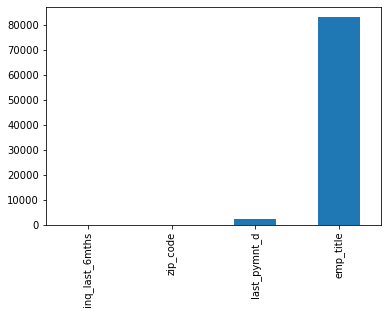

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing

### Feature Engineering

In [6]:
df.drop(df[df['last_pymnt_d'].isna()].index, inplace=True)
df.drop(df[df['inq_last_6mths'].isna()].index, inplace=True)

df['duration']=df['last_pymnt_d']-df['issue_d']
df['duration'] = (df['duration'] / np.timedelta64(1,'D')).astype(int)

df['PnL']=df['total_pymnt']-df['loan_amnt']

### create df_full to get back PnL for model driven portfolio later

In [7]:
df.shape
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average,duration,PnL
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22321809,AR,108000.0,Individual,Cash,25.48,1995-08-01,6,Project Manager,694.0,690.0,D,MORTGAGE,w,2.0,646.08,16.29,2014-07-01,2018-06-01,26400.0,1,30.0,0.0,0.0,debt_consolidation,17,60,37966.739282,Source Verified,720xx,6909,692.0,1431,11566.739282
93612407,IL,41600.0,Individual,Cash,22.82,1980-08-01,0,Dealer Relations Representative,704.0,700.0,B,RENT,f,0.0,389.98,10.49,2016-11-01,2018-07-01,12000.0,1,14.0,1.0,1.0,debt_consolidation,7,36,13585.514958,Source Verified,601xx,13241,702.0,607,1585.514958
59191858,MO,108000.0,Individual,Cash,12.89,2004-10-01,2,Project manager,679.0,675.0,B,MORTGAGE,f,1.0,196.41,10.99,2015-09-01,2018-11-01,6000.0,1,14.0,0.0,0.0,car,9,36,7129.290679,Verified,633xx,3987,677.0,1157,1129.290679
112625148,CA,54000.0,Individual,Cash,13.16,2011-01-01,4,Purchasing Manager,664.0,660.0,C,MORTGAGE,w,2.0,203.88,13.59,2017-07-01,2018-12-01,6000.0,1,8.0,1.0,1.0,debt_consolidation,12,36,6962.351946,Source Verified,906xx,2373,662.0,518,962.351946
66471676,CT,75000.0,Individual,Cash,22.70,1992-03-01,0,Warehouse Manager,664.0,660.0,D,RENT,w,0.0,1063.48,16.59,2015-12-01,2017-12-01,30000.0,0,9.0,0.0,0.0,debt_consolidation,17,36,25322.390000,Verified,066xx,8675,662.0,731,-4677.610000


In [8]:
print(f'Total investment for Model Portfolio: {df.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {df.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(df.PnL.sum()/df.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 18556096200
Total PnL for Model Portfolio: 612451938
Return for Model Portfolio: 3.30%


In [9]:
df36 = df.loc[df['term']==36]
df36= df36.loc[df['issue_d'].dt.year.between(2007,2015)]

In [10]:
print(f'Total investment for Model Portfolio: {df36.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {df36.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(df36.PnL.sum()/df36.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 7668716150
Total PnL for Model Portfolio: 636261024
Return for Model Portfolio: 8.30%


In [11]:
df60 = df.loc[df['term']==60]
df60= df60.loc[df['issue_d'].dt.year.between(2007,2013)]

In [12]:
print(f'Total investment for Model Portfolio: {df60.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {df60.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(df60.PnL.sum()/df60.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 931505175
Total PnL for Model Portfolio: 166819866
Return for Model Portfolio: 17.91%


In [13]:
df_all = pd.concat([df36, df60], axis=0)

In [14]:
print(f'Total investment for Model Portfolio: {df_all.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {df_all.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(df_all.PnL.sum()/df_all.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 8600221325
Total PnL for Model Portfolio: 803080890
Return for Model Portfolio: 9.34%


In [26]:
loan_grade='C'
df_sample = df_all.loc[df_all['grade']==loan_grade]
df_sample.grade.value_counts()

C    179255
Name: grade, dtype: int64

In [27]:
print(f'Total investment for Model Portfolio: {df_sample.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {df_sample.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(df_sample.PnL.sum()/df_sample.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 2255722225
Total PnL for Model Portfolio: 230566444
Return for Model Portfolio: 10.22%


In [ ]:
approved = pd.read_pickle('../data/approved.pickle')

### Convert Ordinals

In [29]:
# # sub_grade
# df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
#                       'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
#                       'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
#                       'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [30]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Filter for years

In [31]:
df= df.loc[df['issue_d'].dt.year.between(2007,2015)]

In [32]:
df.issue_d.dt.year.count()

799772

### Drop Columns

In [33]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line','fico_range_high',
         'fico_range_low','installment'],axis=1, inplace=True)

In [34]:
df.drop(['duration','last_pymnt_d','PnL','total_pymnt'], axis=1, inplace=True)

### Drop emp_length==-1

In [35]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

In [36]:
df = df.dropna(how='all')

### Drop the 60month product

In [37]:
df = df.loc[df['term']==36]
df.drop('term', axis=1, inplace=True)

# Modelling

### create target and features

In [38]:
target = df['loan_status']

In [39]:
target.value_counts()

1    500426
0     76601
Name: loan_status, dtype: int64

In [40]:
features = df.drop(['loan_status'], axis=1)

### note the reduced train_size of .10

In [41]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.10 )
logr = LogisticRegression()

In [42]:
Xtrain.shape

(57702, 84)

### SMOTE to oversample minority class (defaulted loans)

In [43]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(Xtrain, ytrain)

Wall time: 4.71 s


In [44]:
print(y_oversample.value_counts())
print(ytest.value_counts())

1    49980
0    49980
Name: loan_status, dtype: int64
1    450446
0     68879
Name: loan_status, dtype: int64


### gridsearch

In [45]:
Cs = [0.0001,0.001,0.01,1,10,100,1000,10000]
params = [{'C':Cs, 'penalty':['l1','l2']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=3)

In [46]:
%%time
grid_logr.fit(X_oversample, y_oversample)

Wall time: 22.4 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                          'penalty': ['l1', 'l2']}])

In [47]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 0.001, 'penalty': 'l2'}
0.6239395758303322


In [48]:
best_model = grid_logr.best_estimator_
best_model.score(Xtest,ytest)

0.6162075771434073

In [49]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [50]:
coefs.sort_values(0, ascending=False).head(10)

,0
sub_grade,0.051809
int_rate,0.041596
dti,0.039863
open_acc,0.012001
emp_length,0.006628
inq_last_6mths,0.004168
purpose__credit_card,0.003592
initial_list_status,0.003574
fico_score_average,0.002388
home_ownership__RENT,0.002367


### Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])


,Pred_0,Pred_1
True_0,42427,26452
True_1,172861,277585


### Best model is one that strikes good balance of a high "pred_1 precision" and a high "loan approval rate"

In [53]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.59
precision pred_1: 0.91
recall pred_1: 0.62


In [54]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.20      0.62      0.30     68879
           1       0.91      0.62      0.74    450446

    accuracy                           0.62    519325
   macro avg       0.56      0.62      0.52    519325
weighted avg       0.82      0.62      0.68    519325



### Merge test results back into the df to investigate the 'fully paid fails'

In [55]:
model_results = pd.Series(best_model.predict(Xtest), index = Xtest.index, name="loan_status_predict")

In [56]:
df2 = pd.concat([Xtest, ytest, model_results], axis=1 )

In [57]:
fails = df2.loc[(df2['loan_status'] == 0) & (df2['loan_status_predict'] == 1)]
fails

,annual_inc,application_type,disbursement_method,dti,emp_length,initial_list_status,inq_last_6mths,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,sub_grade,verification_status,days_since_first_credit,fico_score_average,purpose__car,purpose__credit_card,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,...,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,home_ownership__ANY,home_ownership__NONE,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,loan_status,loan_status_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54158796,34000.0,0,0,8.12,8,1,3.0,13.99,3600.0,7.0,0.0,0.0,14,0,7335,672.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
6935833,34000.0,0,0,11.36,5,1,0.0,8.90,8000.0,9.0,0.0,0.0,5,0,5753,707.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3644982,29823.0,0,0,11.40,3,1,1.0,14.33,10000.0,7.0,0.0,0.0,11,1,2131,702.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
50233800,55000.0,0,0,19.11,5,0,0.0,11.53,4000.0,11.0,0.0,0.0,10,0,5202,682.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
799313,60000.0,0,0,4.72,10,1,1.0,13.99,5400.0,8.0,0.0,0.0,13,1,6512,677.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55967440,186000.0,0,0,2.18,10,1,4.0,15.61,15000.0,11.0,0.0,0.0,16,1,3103,707.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1242216,119000.0,0,0,9.99,10,1,3.0,15.31,16000.0,21.0,1.0,1.0,13,0,8552,692.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32199411,64800.0,0,0,25.00,1,1,0.0,10.15,9000.0,13.0,1.0,1.0,7,0,9345,662.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


### PnL analysis

In [58]:
model_port = df2.loc[df2['loan_status_predict'] == 1]

In [59]:
PnL = df_full['PnL']

In [60]:
model_port = model_port.merge(PnL, how='inner',left_index=True,right_index=True)

In [61]:
print(f'Total investment for Model Portfolio: {model_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {model_port.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(model_port.PnL.sum()/model_port.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 3985195325
Total PnL for Model Portfolio: 340429811
Return for Model Portfolio: 8.54%


In [62]:
null_port = df2.merge(PnL, how='inner',left_index=True,right_index=True)

In [64]:
print(f'Total investment for Null Portfolio: {null_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Null Portfolio: {null_port.PnL.sum():.0f}')
print(f'Return for Null Portfolio: {(null_port.PnL.sum()/null_port.loan_amnt.sum())*100:.2f}%')

Total investment for Null Portfolio: 6574531275
Total PnL for Null Portfolio: 552100998
Return for Null Portfolio: 8.40%


In [65]:
null_port.shape

(519325, 87)

In [138]:
null_port.loc[null_port['loan_status_predict'] == 0].PnL.sum()

215537568.11461204

In [140]:
null_port.loc[(null_port['loan_status_predict'] == 0) & (null_port['loan_status'] == 0)].PnL.sum()

-193354091.0400848

In [141]:
null_port.loc[(null_port['loan_status_predict'] == 0) & (null_port['loan_status'] == 1)].PnL.sum()

408891659.1546968

In [142]:
null_port.loan_status_predict.value_counts()

1    305580
0    213745
Name: loan_status_predict, dtype: int64

### Research the model fails

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

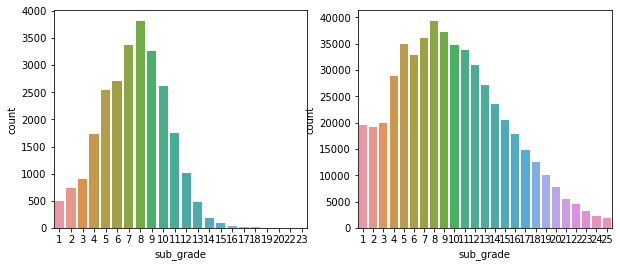

In [83]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
sns.countplot(x=fails['sub_grade'],ax=ax1)
sns.countplot(x=Xtest['sub_grade'],ax=ax2)

(0.0, 40.0)

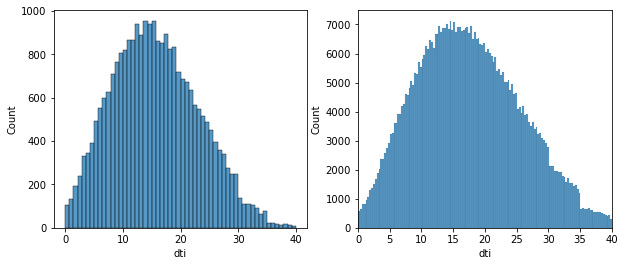

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="dti", ax=ax1)
sns.histplot(data=Xtest, x="dti", ax=ax2)
plt.xlim(0, 40)
# plt.show()

<AxesSubplot:xlabel='int_rate', ylabel='Count'>

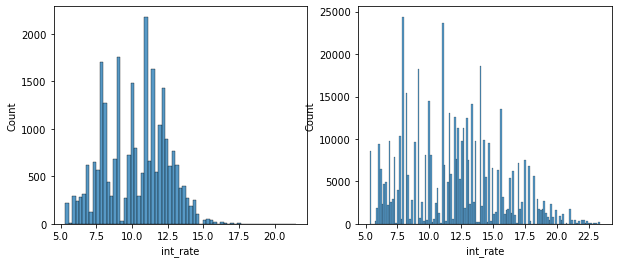

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="int_rate", ax=ax1)
sns.histplot(data=Xtest, x="int_rate", ax=ax2)

<AxesSubplot:xlabel='emp_length', ylabel='Count'>

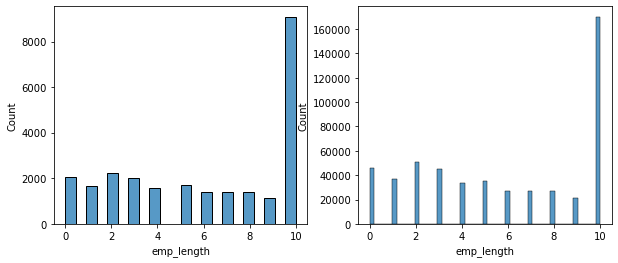

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="emp_length", ax=ax1)
sns.histplot(data=Xtest, x="emp_length", ax=ax2)

<AxesSubplot:xlabel='fico_score_average', ylabel='Count'>

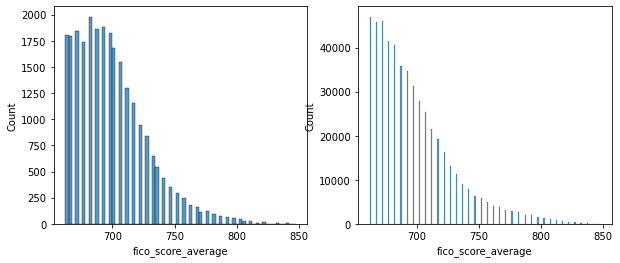

In [87]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="fico_score_average", ax=ax1)
sns.histplot(data=Xtest, x="fico_score_average", ax=ax2)

<AxesSubplot:xlabel='open_acc', ylabel='Count'>

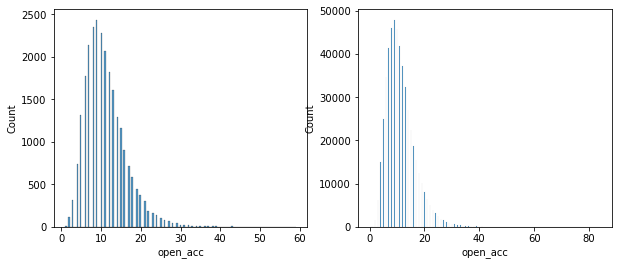

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="open_acc", ax=ax1)
sns.histplot(data=Xtest, x="open_acc", ax=ax2)

### change the threshold to improve the pred_1 precision

In [31]:
probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
prediction = probs_positive_class > .6

In [32]:
cmat2 = confusion_matrix(ytest, prediction, labels=[0, 1])
pd.DataFrame(cmat2, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

,Pred_0,Pred_1
True_0,60518,8620
True_1,317610,132956


In [33]:
from sklearn.metrics import classification_report
print(classification_report(ytest, prediction))

              precision    recall  f1-score   support

           0       0.16      0.88      0.27     69138
           1       0.94      0.30      0.45    450566

    accuracy                           0.37    519704
   macro avg       0.55      0.59      0.36    519704
weighted avg       0.84      0.37      0.43    519704



In [34]:
cmat=cmat2
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.27
precision pred_1: 0.94
recall pred_1: 0.30


### Loop to check thresholds

In [35]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(ytest, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

threshold:0.50
loan approval rate: 0.58
precision pred_1: 0.91
recall pred_1: 0.61
--------------------------------------------------
threshold:0.53
loan approval rate: 0.47
precision pred_1: 0.92
recall pred_1: 0.50
--------------------------------------------------
threshold:0.56
loan approval rate: 0.39
precision pred_1: 0.93
recall pred_1: 0.41
--------------------------------------------------
threshold:0.58
loan approval rate: 0.31
precision pred_1: 0.94
recall pred_1: 0.34
--------------------------------------------------
threshold:0.61
loan approval rate: 0.25
precision pred_1: 0.94
recall pred_1: 0.27
--------------------------------------------------
threshold:0.64
loan approval rate: 0.19
precision pred_1: 0.94
recall pred_1: 0.21
--------------------------------------------------
threshold:0.67
loan approval rate: 0.15
precision pred_1: 0.95
recall pred_1: 0.17
--------------------------------------------------
threshold:0.69
loan approval rate: 0.12
precision pred_1: 0.95

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# predict probabilities
yhat = logr.predict_proba(Xtest)

In [ ]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, prediction)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### SGD classifier

### Save model in pickle

In [ ]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)